# ∇ Gradient descent training of a rate-based recurrent network

## Requirements

In [1]:
# - Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# - Imports and boilerplate
from rockpool import TimeSeries, TSContinuous
from rockpool.nn.modules import RateJax, LinearJax
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from tqdm import tnrange
from tqdm.autonotebook import tqdm

# - Numpy
import numpy as np
import numpy.random as npr

# - Matplotlib
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 4]
plt.rcParams["figure.dpi"] = 300

# - Pretty printing
try:
    from rich import print
except:
    pass

## Triggered signal-generation task

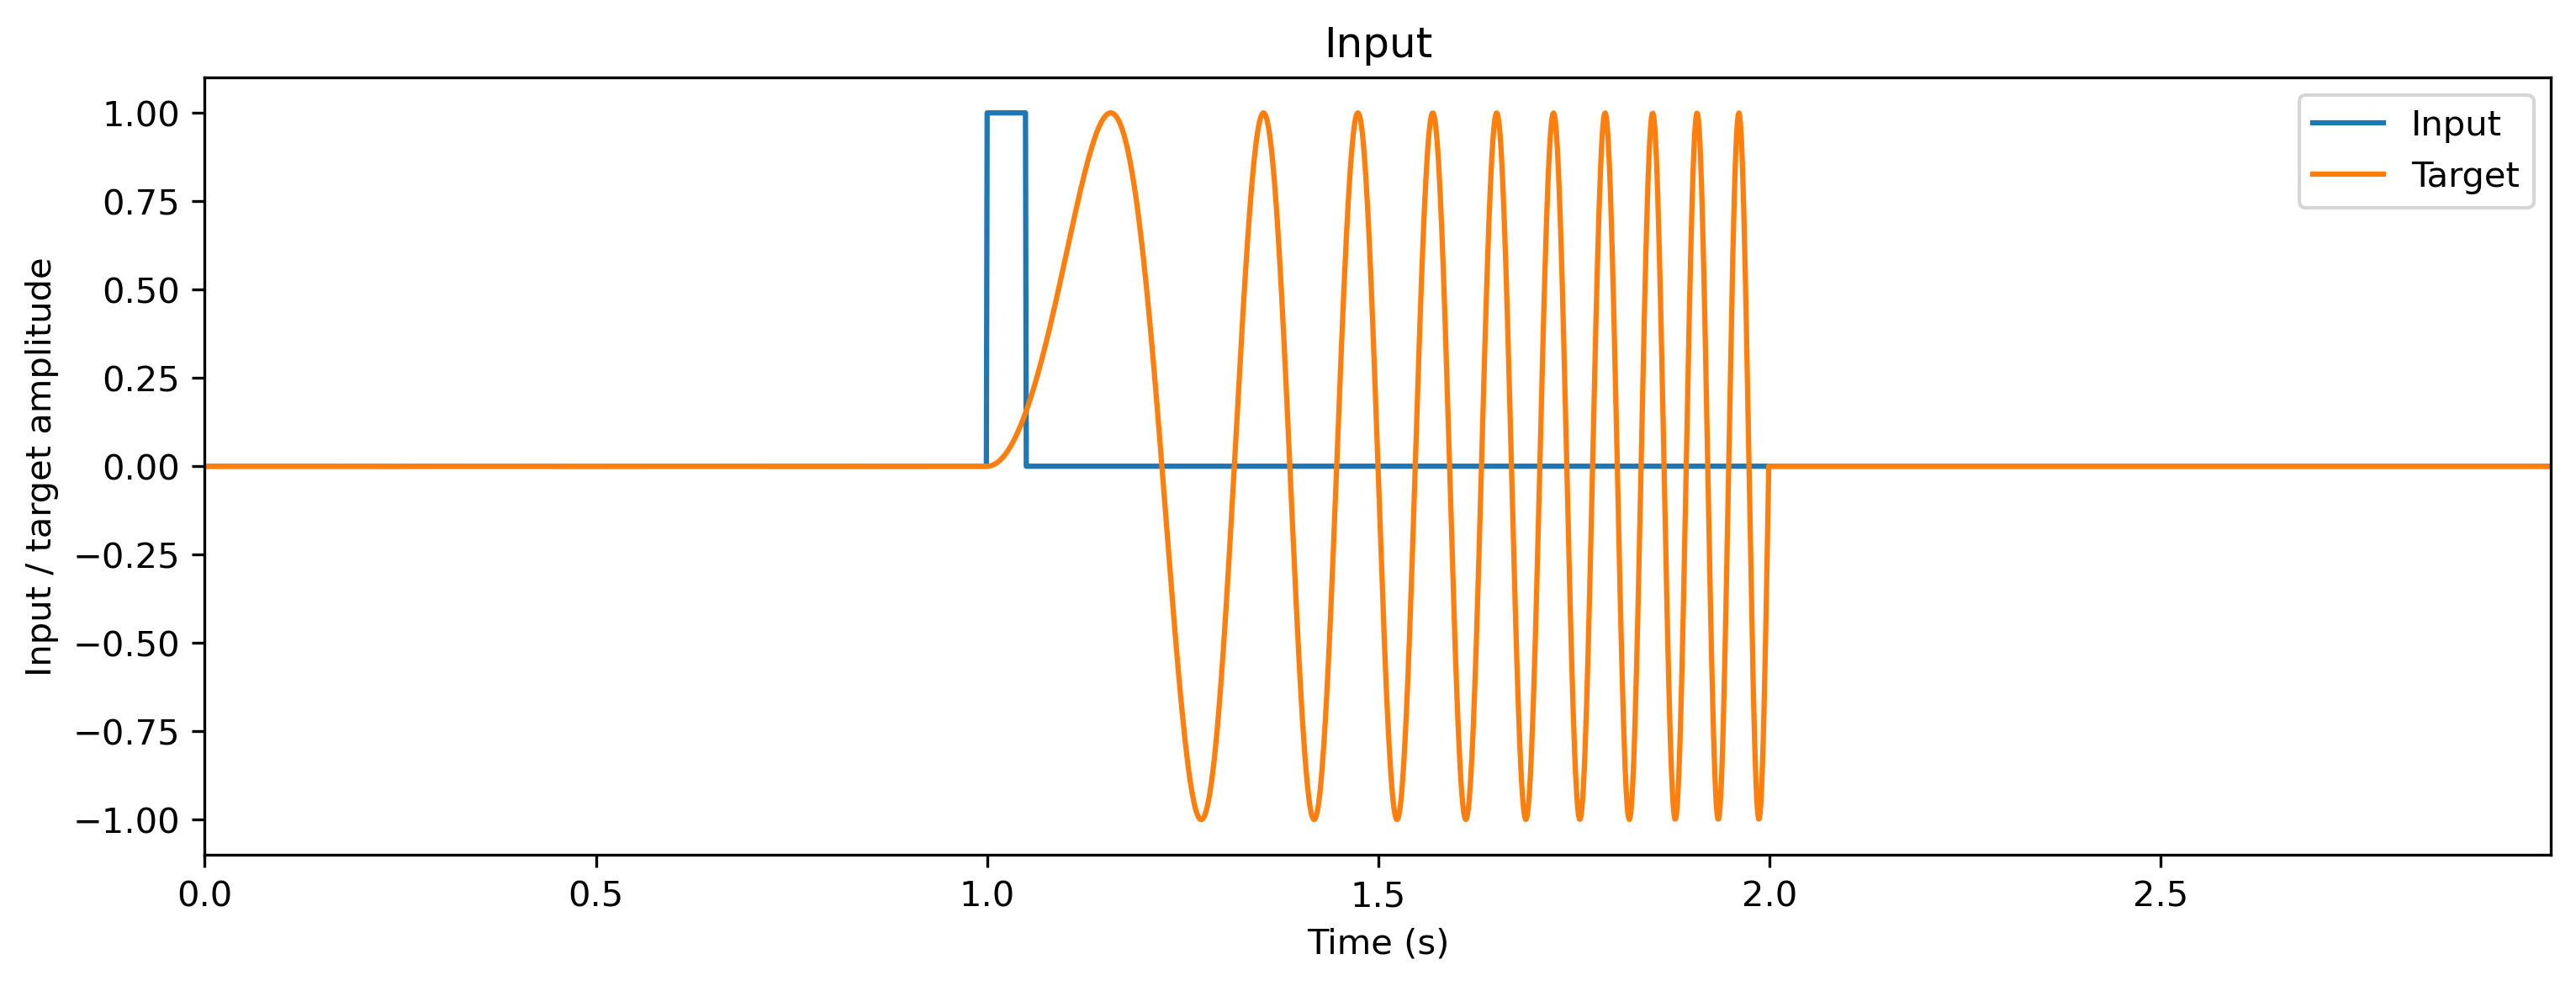

In [2]:
# - Define input and target signals
num_repeats = 1
pulse_duration = 50e-3
chirp_freq_factor = 10
padding_duration = 1
chirp_duration = 1
dt = 1e-3

# - Build chirp and trigger signals
chirp_end = int(np.round(chirp_duration / dt))
chirp_timebase = np.linspace(0, chirp_end * dt, chirp_end)
chirp = np.atleast_2d(
    np.sin(chirp_timebase * 2 * np.pi * (chirp_timebase * chirp_freq_factor))
).T
trigger = np.atleast_2d(chirp_timebase < pulse_duration).T

# - Add padding
padding = np.zeros((int(np.round(padding_duration / dt)), 1))
chirp = np.vstack((padding, chirp, padding))
trigger = np.vstack((padding, trigger, padding))

# - Build a time base
num_samples = (chirp_end + len(padding) * 2) * num_repeats
timebase = np.linspace(0, num_samples, num_samples + 1)
timebase = timebase[:-1] * dt

# - Replicate out inputs and target signals
input_t = np.tile(trigger * 1.0, (num_repeats, 1))
target_t = np.tile(chirp, (num_repeats, 1))

# - Generate time series objects
ts_input = TSContinuous.from_clocked(input_t, dt=dt, periodic=True, name="Input")
ts_target = TSContinuous.from_clocked(target_t, dt=dt, periodic=True, name="Target")

# - Plot the input and target signals
plt.figure()
ts_input.plot()
ts_target.plot()
plt.xlabel("Time (s)")
plt.ylabel("Input / target amplitude")
plt.legend();

## Network model

The dynamics of a unit $j$ in the recurrent layer is given by

$$
\tau_j\frac{\textrm{d}{x_j}}{\textrm{d}t} + {x_j} = W_r \cdot f(\textbf{x}) + b_j + i_j + \sigma\zeta_j(t)
$$

where $\tau_j$ is the time constant of the unit (`tau`); $W_r$ is the $N \times N$ weight matrix defining the recurrent connections; $\textbf{x}$ is the vector of recurrent layer activities (`w_rec`); $f(x)$ is the neuron transfer function $\tanh(x)$; $b_j$ is the bias input of the unit (`bias`); $i_j$ is the external input to the unit; and $\sigma\zeta_j(t)$ is a white noise Wiener process with standard deviation $\sigma$ (`noise_std`) after 1s.

External input is weighted such that $\textbf{i} = W_i \cdot i(t)$, where $W_i$ is the external input weight matrix (`w_in`) and $i(t)$ is the external input function.

The output of the reservoir is also weighted such that $z = W_o \cdot \textbf{x}$, where $W_o$ is the output weight matrix (`w_out`). The goal of the training task is to match the reservoir output $\hat{z}$ with a target signal $z^*$.

Weight initialisation doesn't seem to matter too much in this process; gradient descent does a good job even when weights are initially zero. Here we use a standard initialisation with unit spectral radius for the recurrent weights.

You can change the activation function to one of `'tanh'` or `'relu'`. You can also define your own, but must use `jax.numpy` to do so.

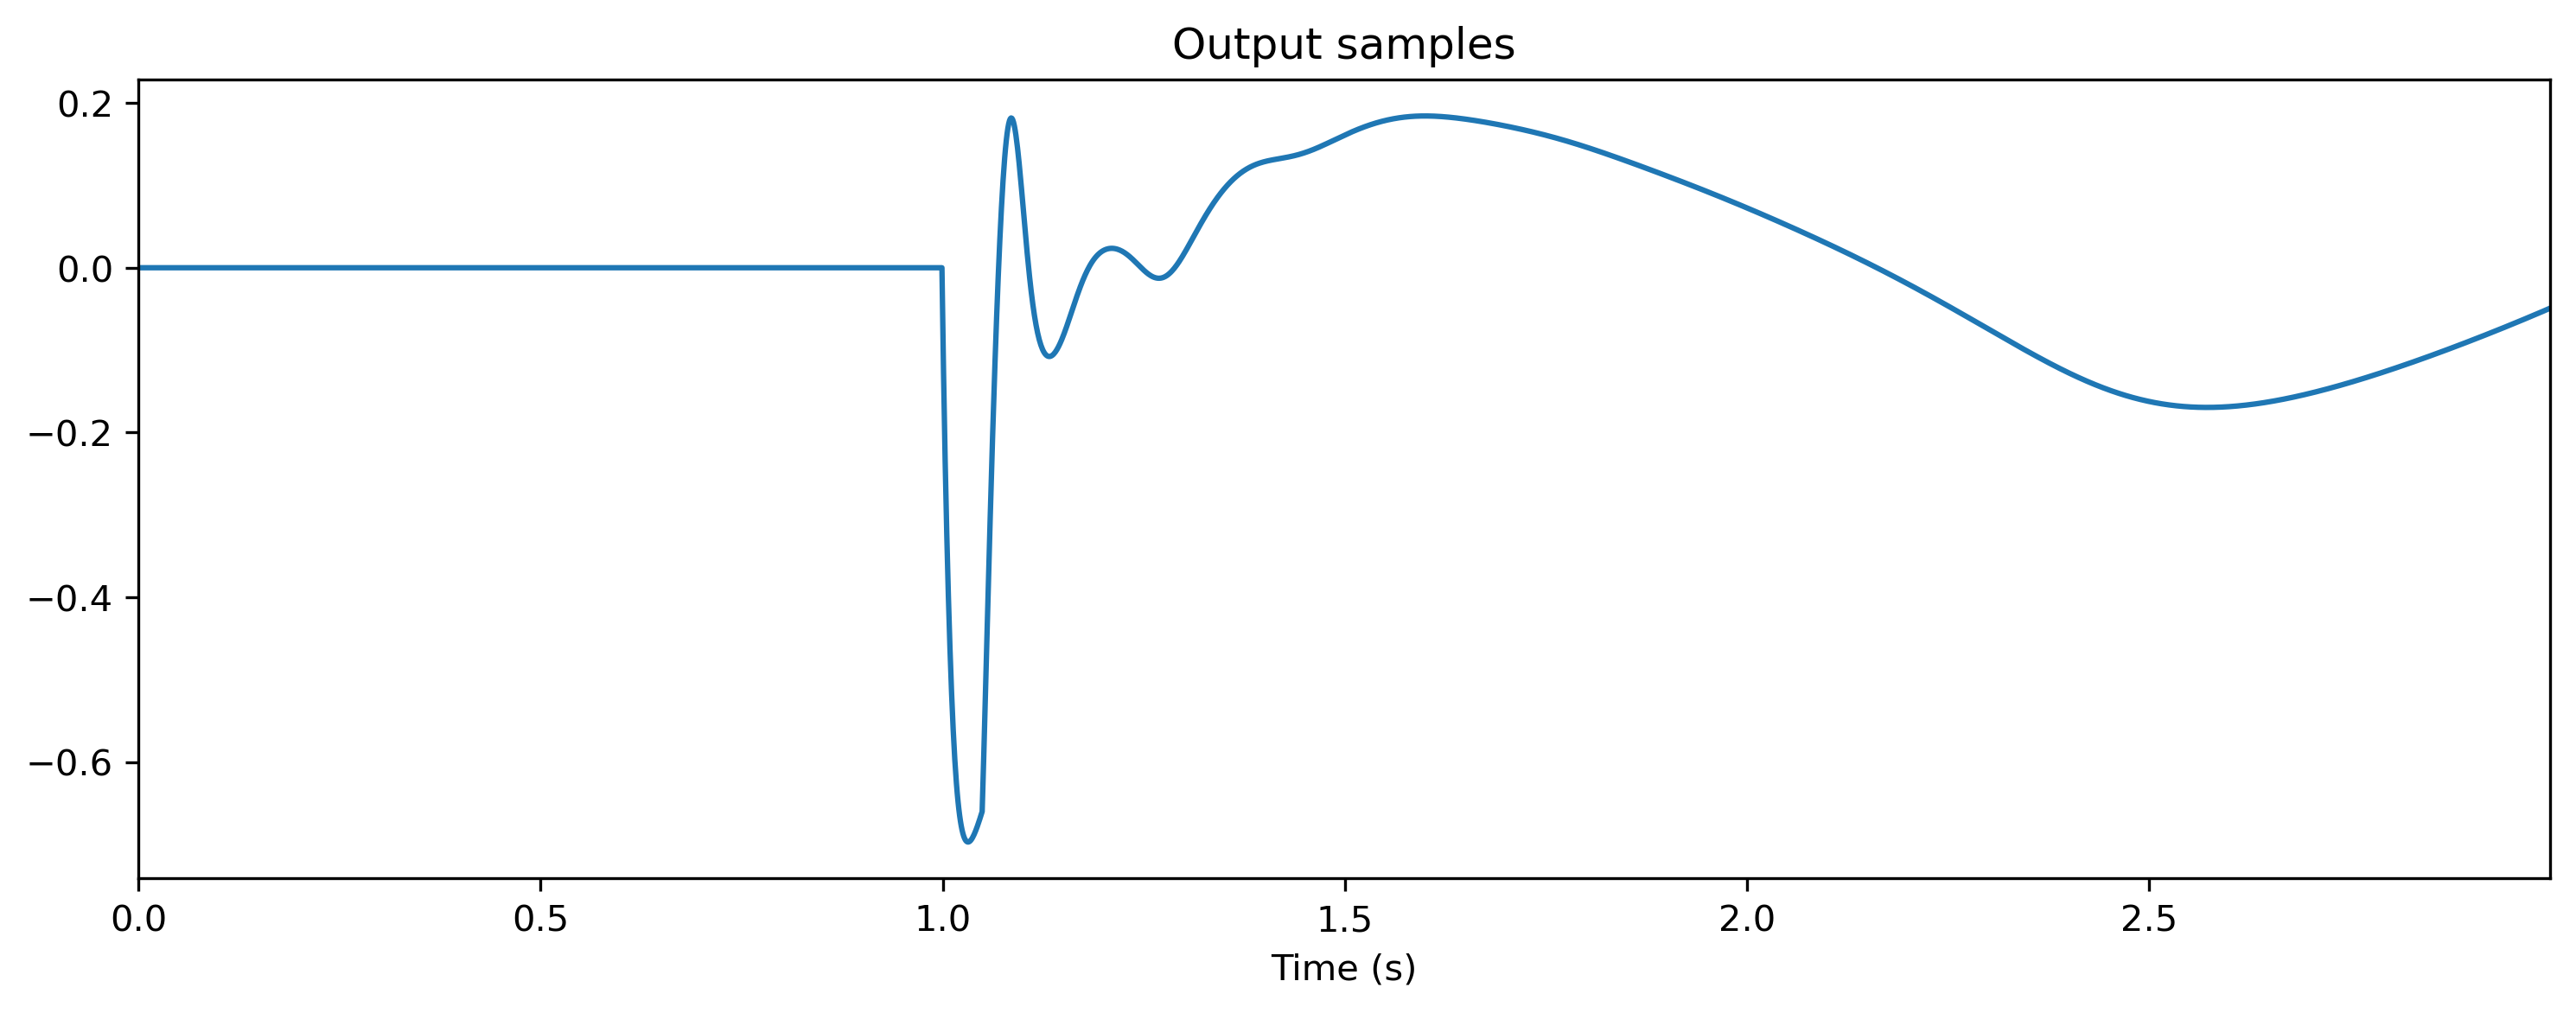

In [3]:
# - Define the reservoir parameters
nResSize = 50
activation_func = "tanh"
noise_std = 0.1

# - Build a network
nInSize = 1
nOutSize = 1

modRNN = Sequential(
    LinearJax((nInSize, nResSize)),
    RateJax((nResSize, nResSize), has_rec=True, activation_func=activation_func, dt=dt),
    LinearJax((nResSize, nOutSize)),
).timed(dt=dt)

# - Record initial weights
w_rec0 = modRNN._module[1].w_rec
tau0 = modRNN._module[1].tau

# - Get initial output and plot
ts_output0, _, _ = modRNN(ts_input)
ts_output0.plot();

In [4]:
# - Import the convenience functions
from rockpool.training.jax_loss import bounds_cost, make_bounds

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(modRNN.module.parameters())
print("lower_bounds: ", lower_bounds, "upper_bounds: ", upper_bounds)

lower_bounds:  {'0_LinearJax': {'weight': -inf}, '1_RateJax': {'bias': -inf, 'tau': -inf, 'threshold': -inf, 'w_rec': -inf}, '2_LinearJax': {'weight': -inf}} upper_bounds:  {'0_LinearJax': {'weight': inf}, '1_RateJax': {'bias': inf, 'tau': inf, 'threshold': inf, 'w_rec': inf}, '2_LinearJax': {'weight': inf}}


In [5]:
# - Impose a lower bound for the time constants
lower_bounds["1_RateJax"]["tau"] = 11 * dt

In [6]:
# - Define a constrained MSE loss function
import rockpool.training.jax_loss as l


def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    net = net.reset_state()

    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)

    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)

    # - Impose the bounds
    bounds = bounds_cost(parameters, lower_bounds, upper_bounds)

    # - Regularise recurrent weights
    reg_l2 = l.l2sqr_norm(parameters["1_RateJax"]["w_rec"])

    # - Compute a loss value w.r.t. the target output
    return l.mse(output[0], target) + 10.0 * bounds + reg_l2

In [7]:
# - Useful imports
from copy import deepcopy
from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.example_libraries.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-4)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(modRNN.module.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 6000

In [8]:
# - Loop over iterations
i_trial = count()
for _ in tqdm(range(num_epochs)):
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, modRNN.module, input_t, target_t)

    # - Update the optimiser
    opt_state = update_fun(next(i_trial), grads, opt_state)

    # - Keep track of the loss
    loss_t.append(loss_val)

  0%|          | 0/6000 [00:00<?, ?it/s]

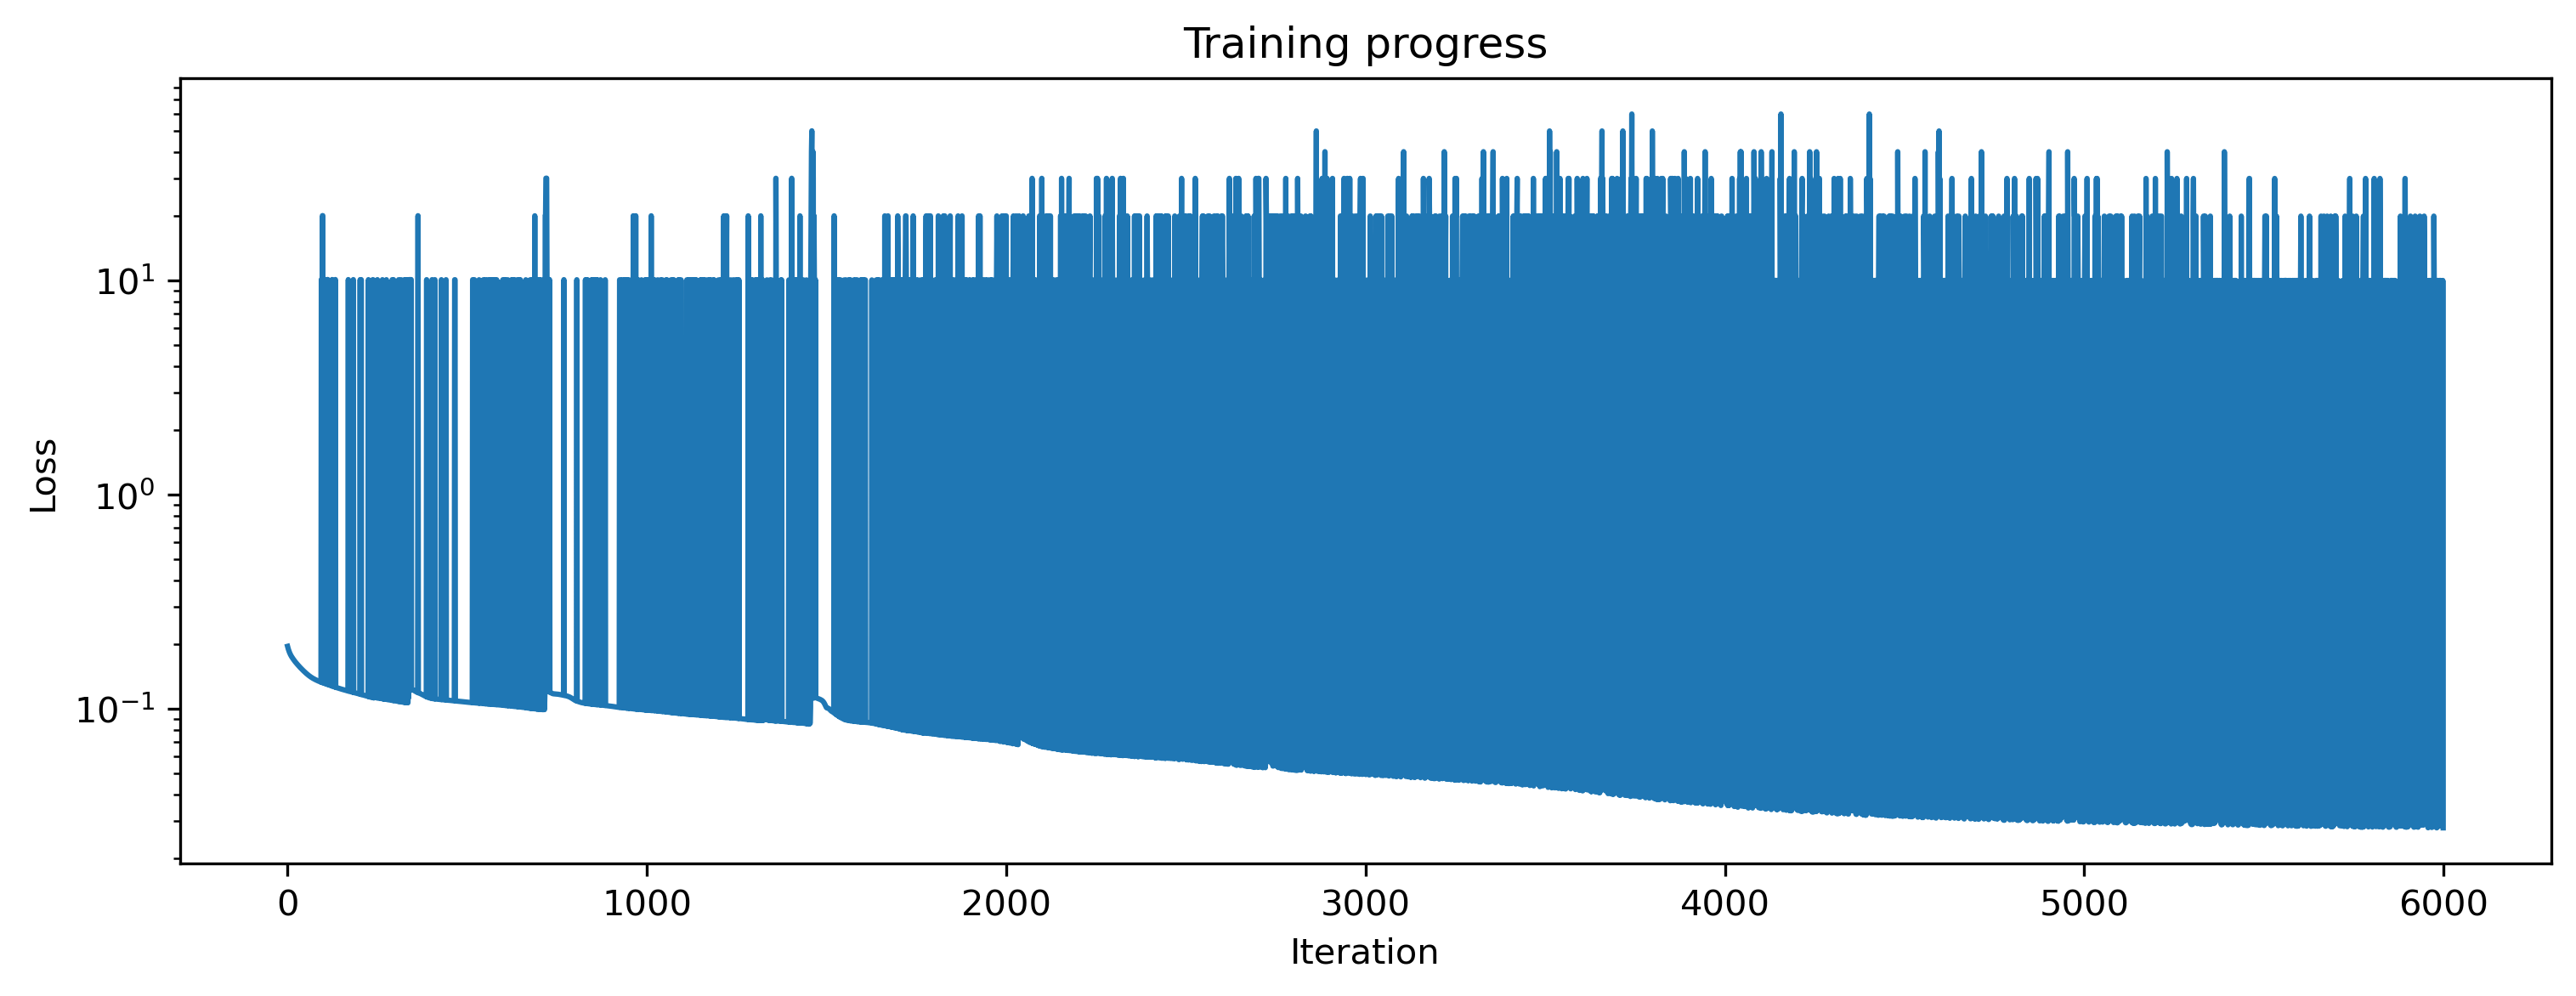

In [9]:
# - Plot the loss curve over training
plt.plot(loss_t)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training progress");

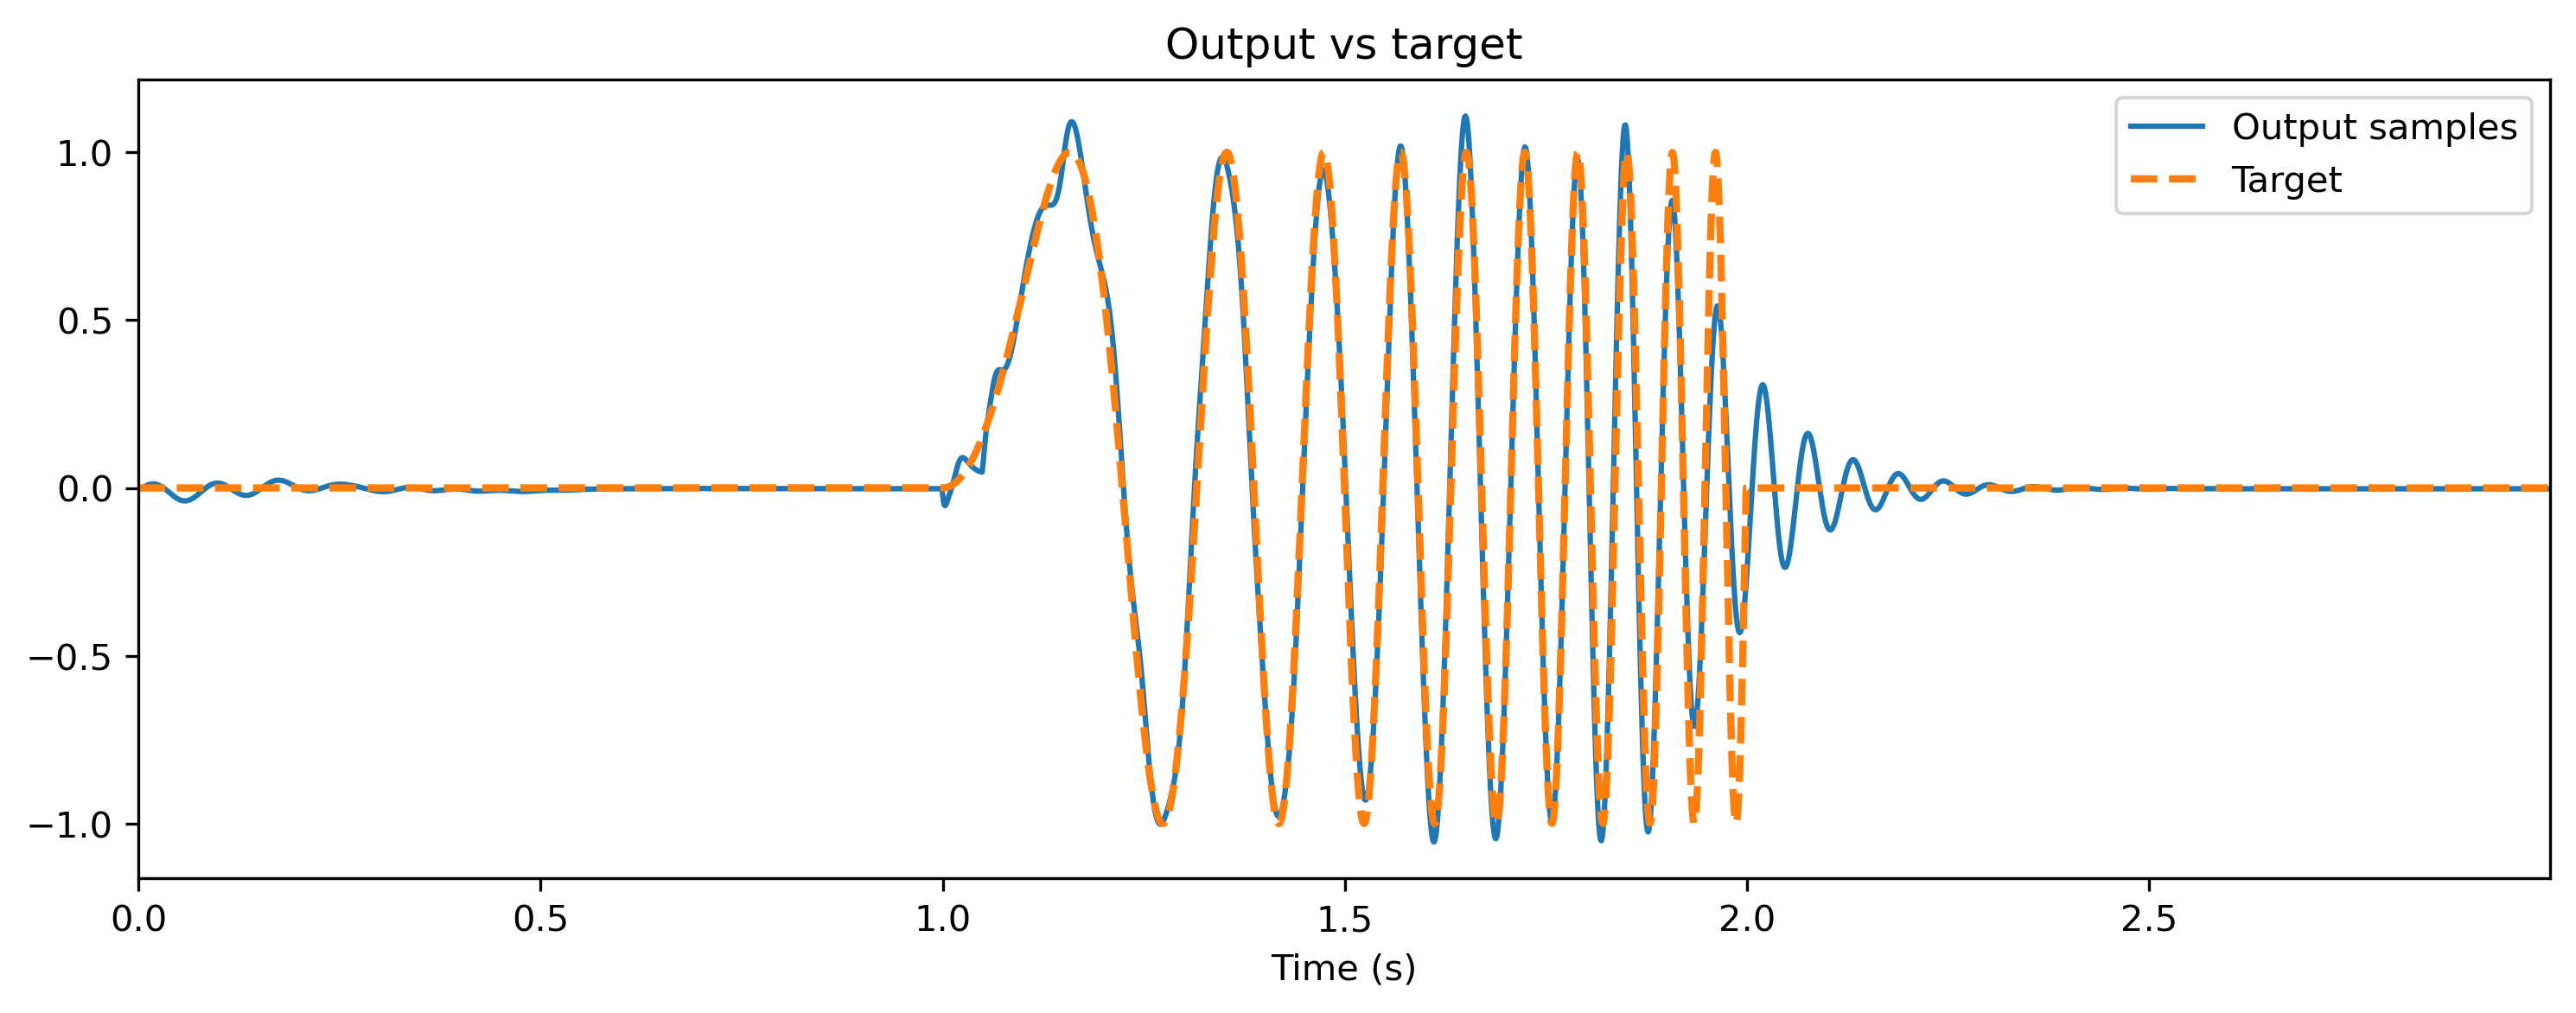

In [10]:
# - Plot the output of the trained reservoir
# - Simulate with trained parameters
modRNN._module = modRNN._module.set_attributes(get_params(opt_state))
modRNN.reset_all()
ts_output, _, record_dict = modRNN(ts_input)

# - Compare the output to the target
ts_output.plot()
ts_target.plot(ts_output.times, ls="--", lw=2)
plt.legend()
plt.title("Output vs target");

If all has gone according to plan, the output of the reservoir should closely match the target signal. We can see the effect of training by examining the distribution of network parameters below.

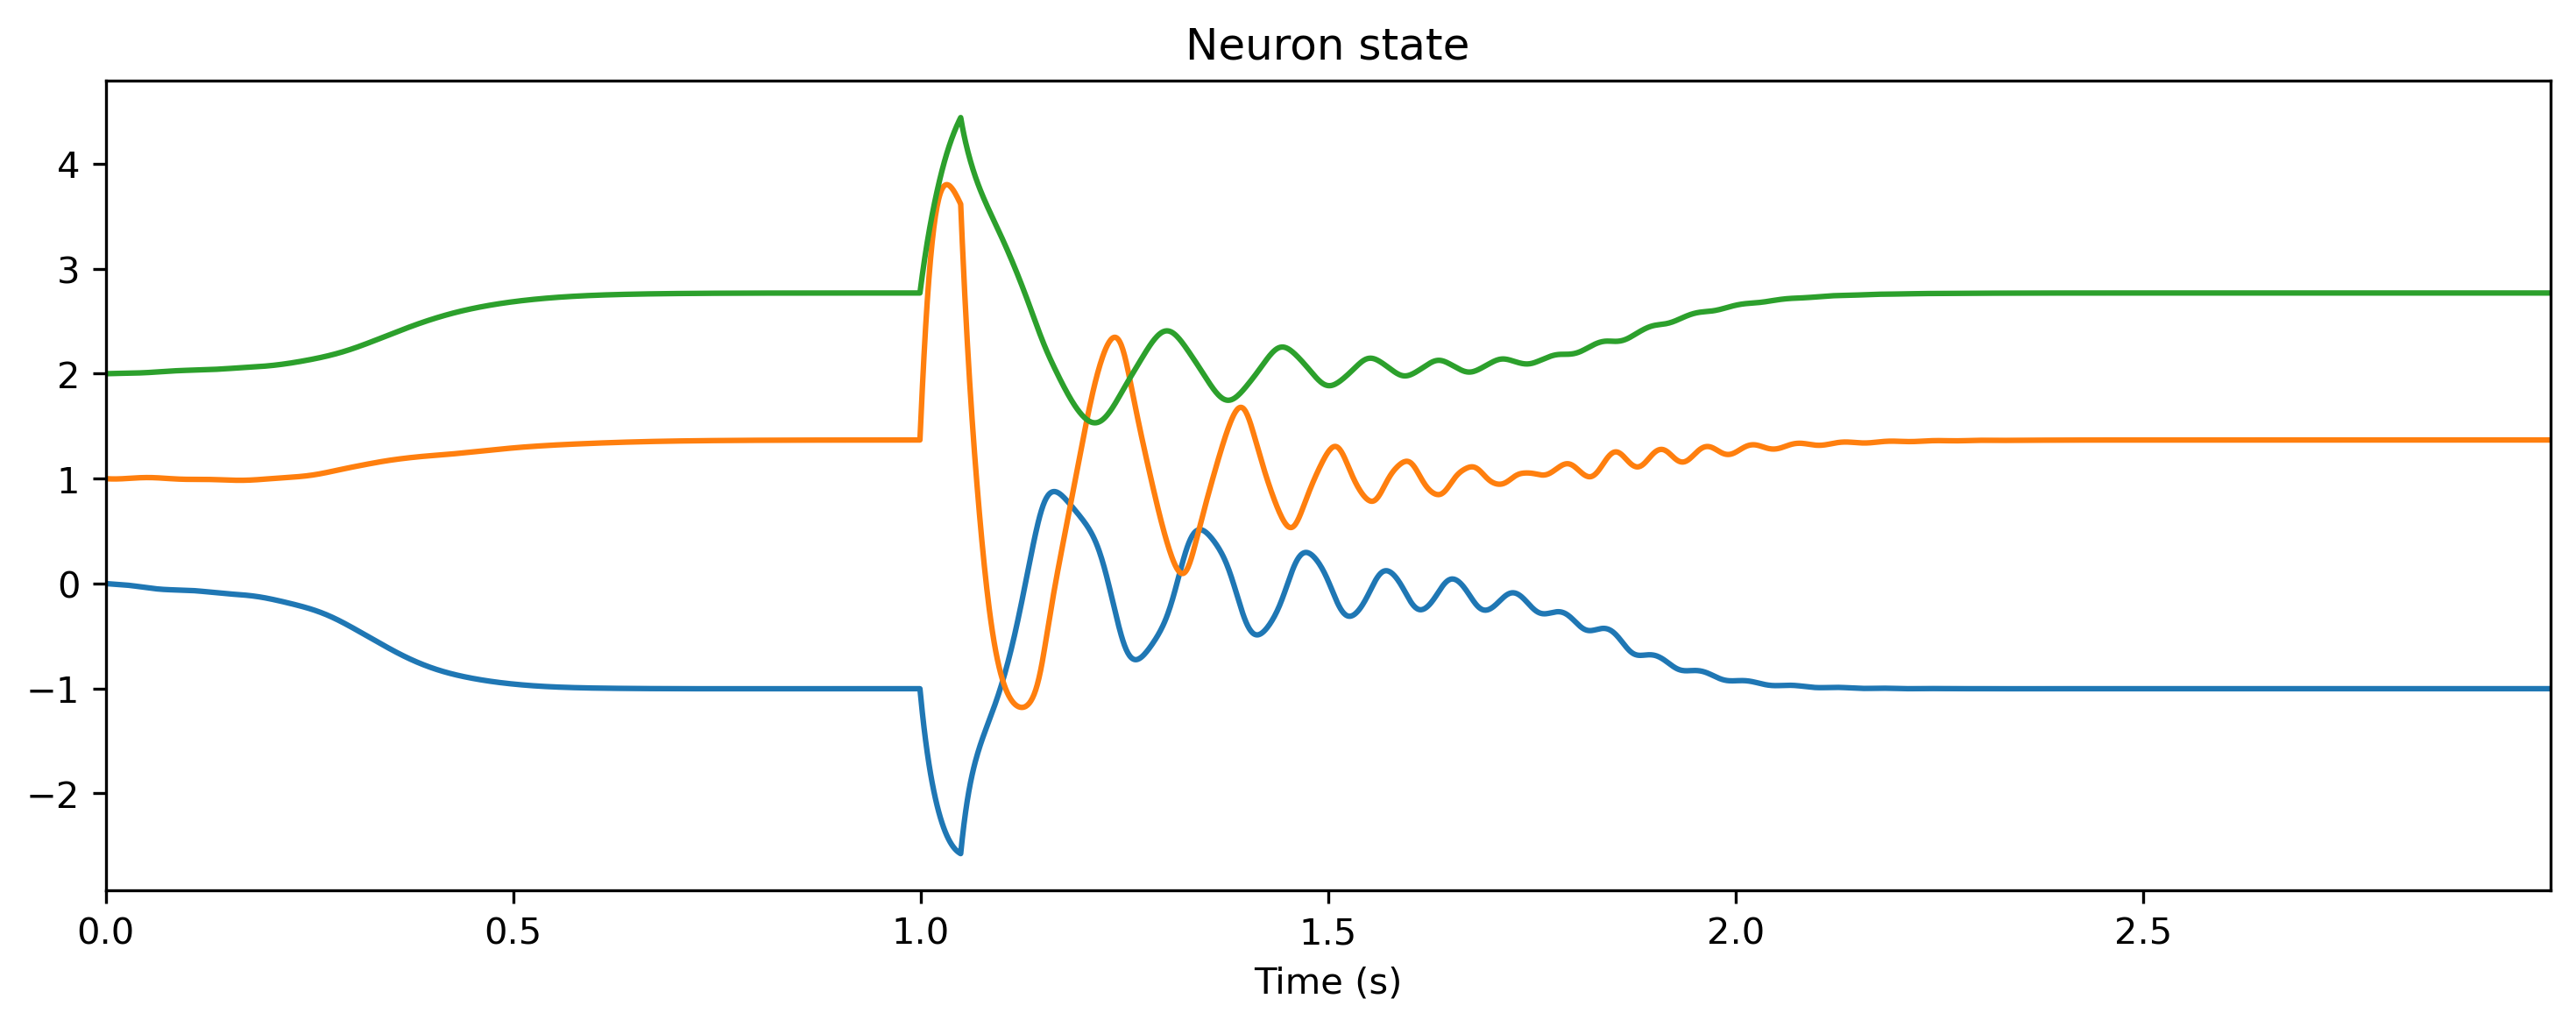

In [11]:
TSContinuous.from_clocked(
    record_dict["1_RateJax"]["x"][0], dt=dt, name="Neuron state"
).plot(skip=20, stagger=1);

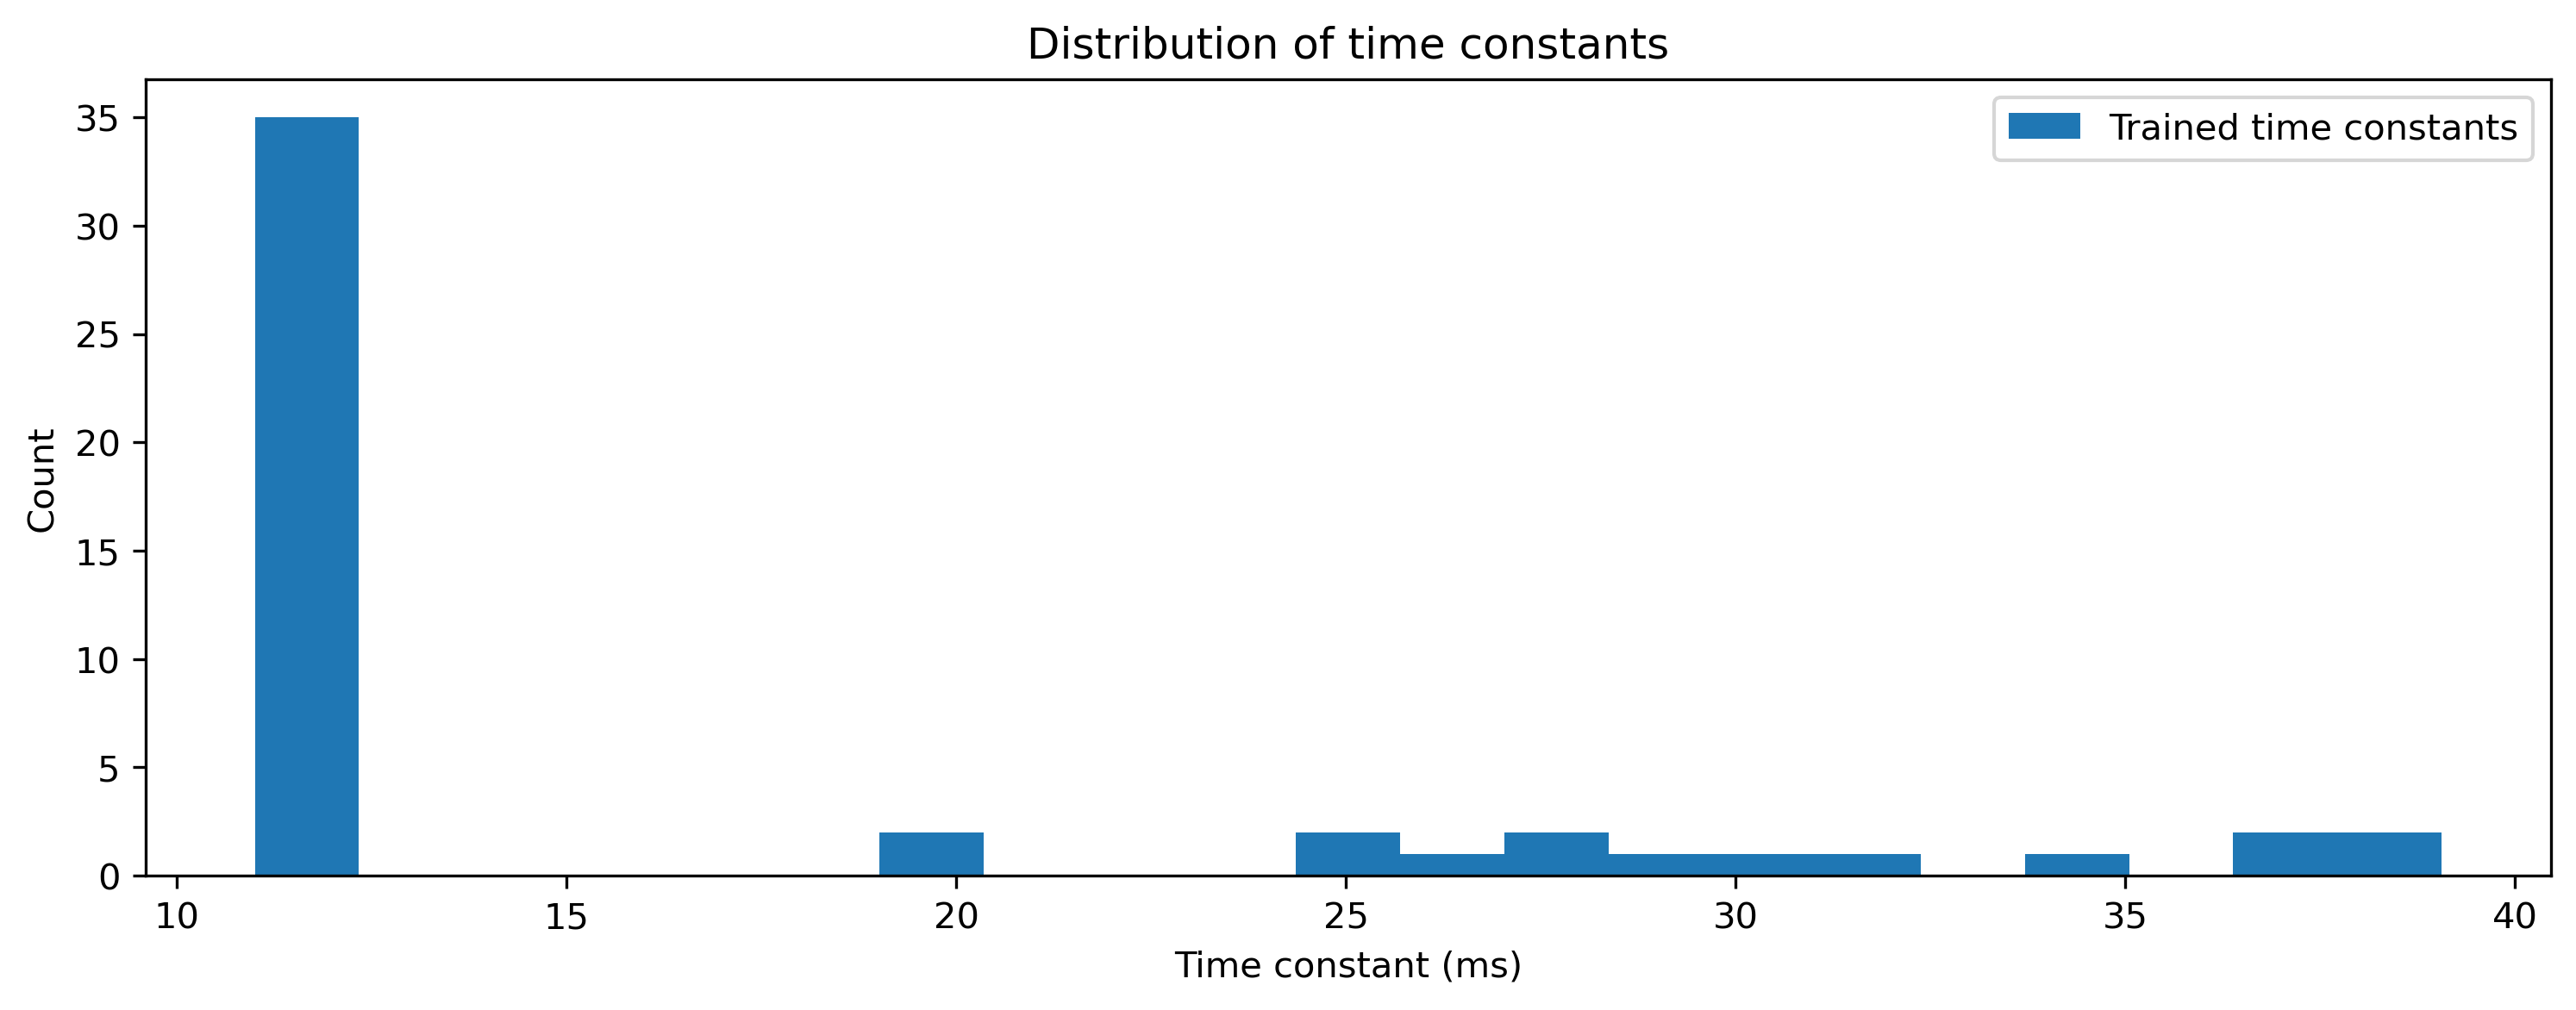

In [12]:
# - Plot the network time constants
plt.figure()
plt.hist(modRNN._module[1].tau / 1e-3, 21)
plt.legend(["Trained time constants"])
plt.xlabel("Time constant (ms)")
plt.ylabel("Count")
plt.title("Distribution of time constants");

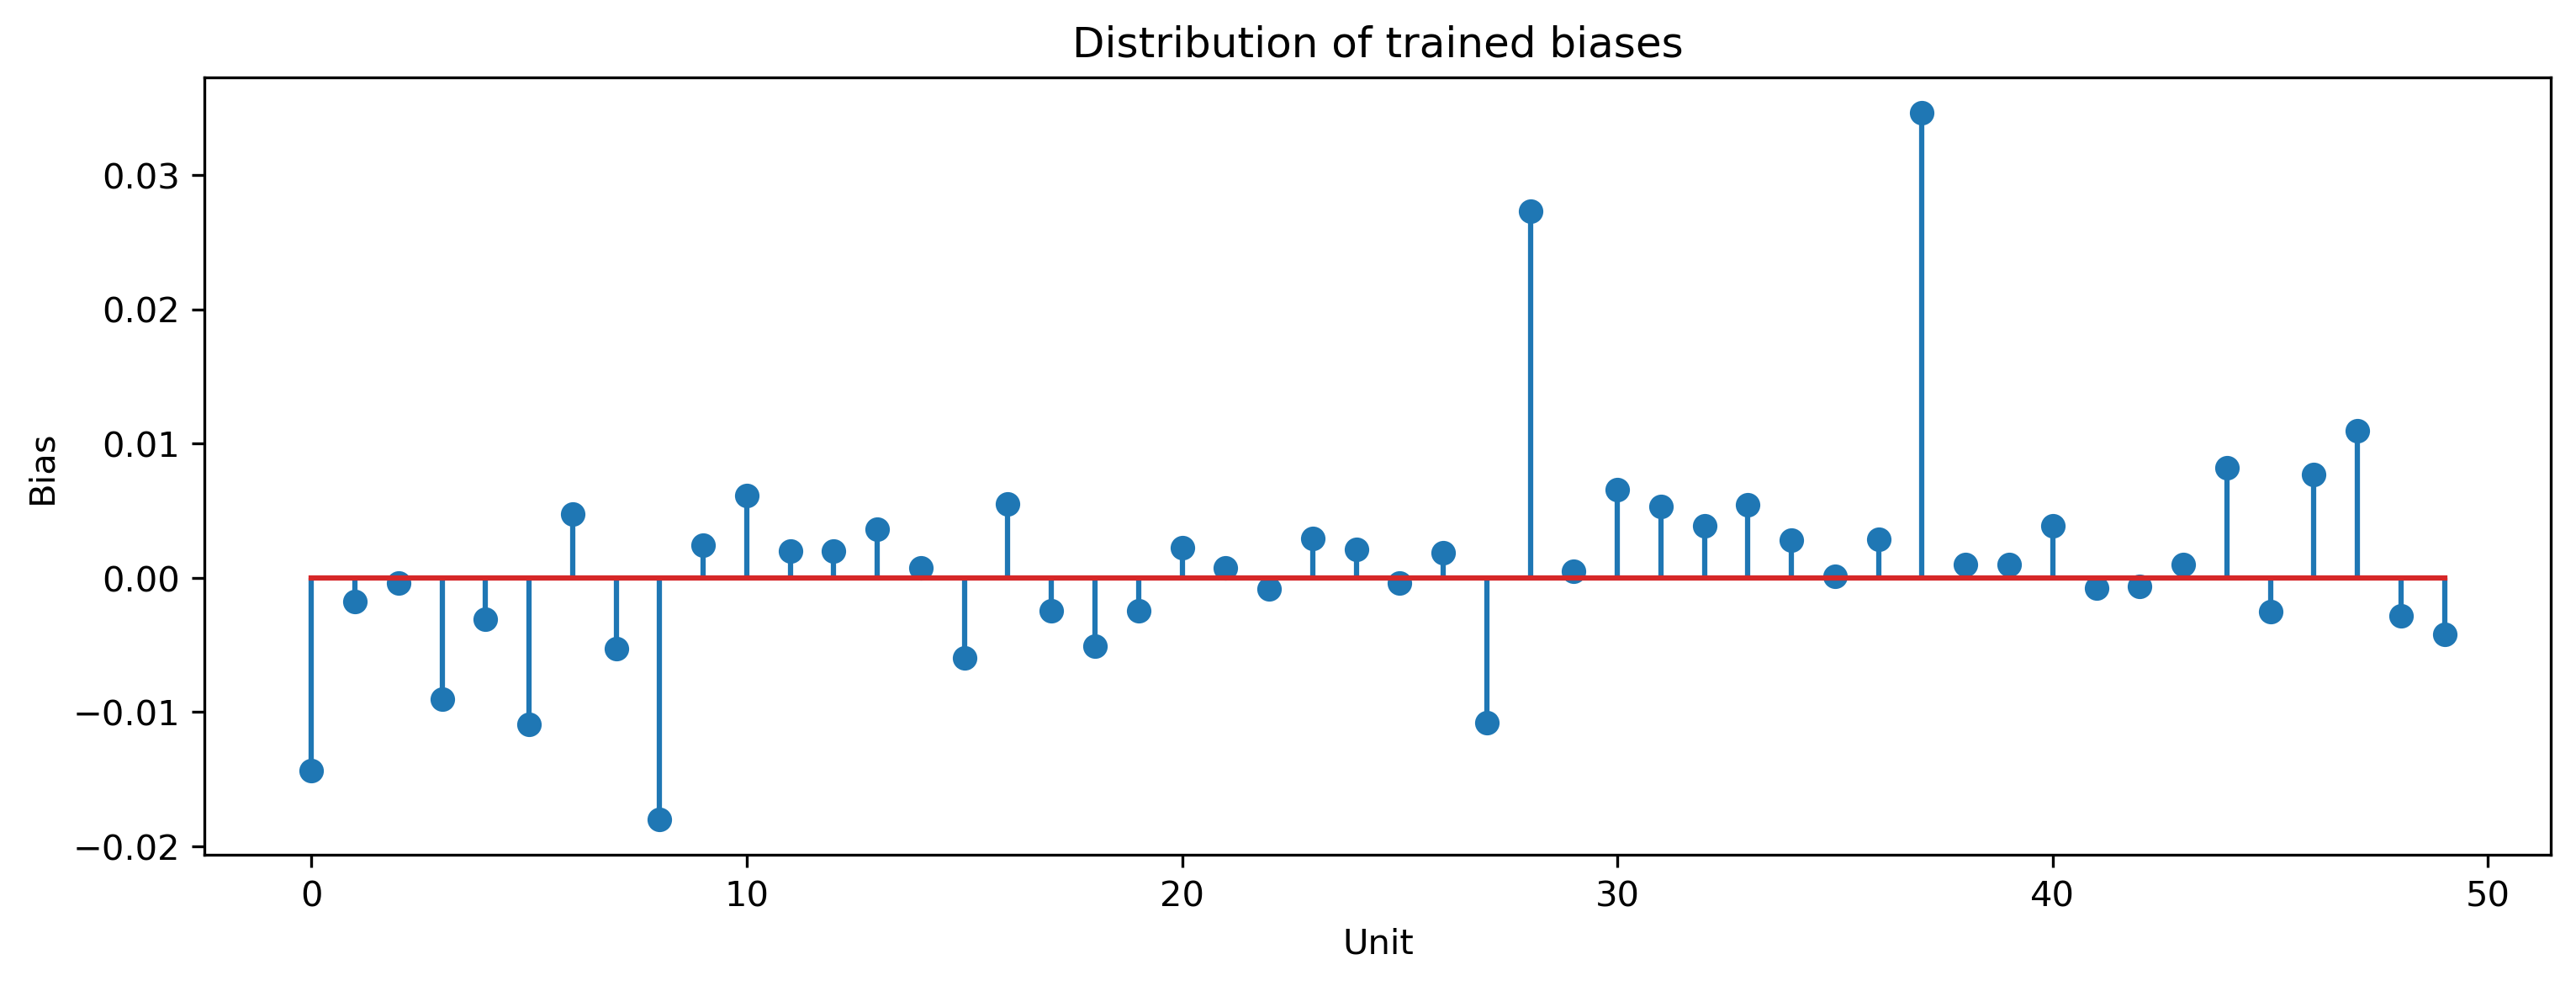

In [13]:
# - Plot the recurrent layer biases
plt.figure()
plt.stem(modRNN._module[1].bias)
plt.title("Distribution of trained biases")
plt.xlabel("Unit")
plt.ylabel("Bias");

We can examine something of the computational properties of the network by finding the eigenspectrum of the Jacobian of the recurrent layer. The Jacobian $\hat{J}$ is given by

$$
\hat{J} = (\hat{W_r} - I) ./ \hat{T}
$$

where $I$ is the identity matrix, $./$ denotes element-wise division, and $T$ is the matrix composed of all time constants $\hat{\tau}$ of the recurrent layer.

Below we plot the eigenvalues $\lambda$ of $J$. In my training result, several complex eigenvalues $\lambda$ with real parts greater than zero are present in the trained eigenspectrum. These correspond to oscillatory modes, which are obviously useful in generating the chirp output.

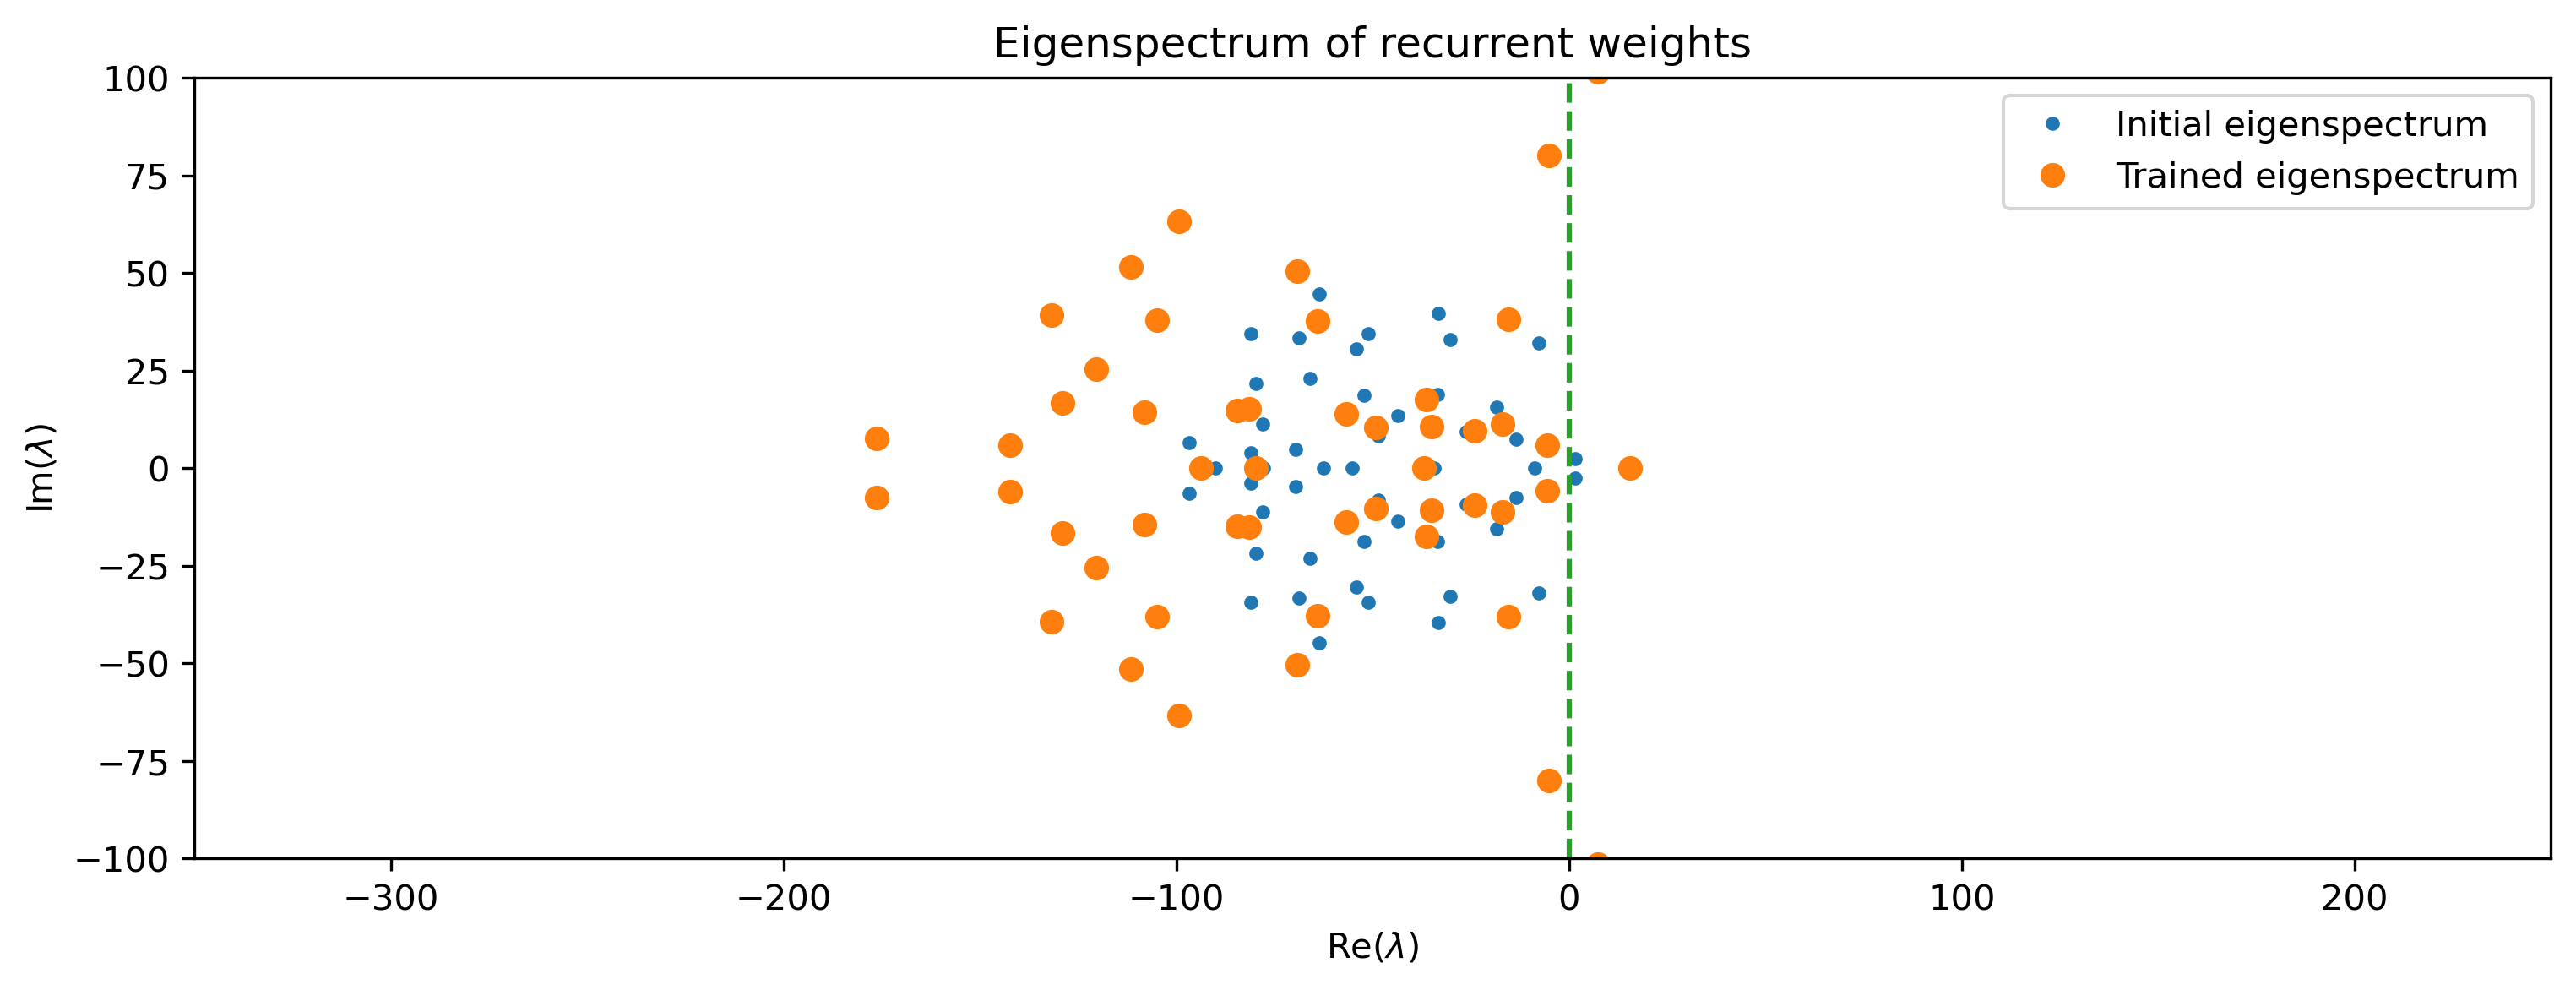

: 

In [14]:
# - Plot the recurrent layer eigenspectrum
J = modRNN._module[1].w_rec - np.identity(nResSize)
J = J / modRNN._module[1].tau

J0 = w_rec0 - np.identity(nResSize)
J0 = J0 / tau0

plt.figure()
eigs = np.linalg.eigvals(J)
eigs0 = np.linalg.eigvals(J0)
plt.plot(np.real(eigs0), np.imag(eigs0), ".")
plt.plot(np.real(eigs), np.imag(eigs), "o")
plt.plot([0, 0], [-100, 100], "--")
plt.legend(
    (
        "Initial eigenspectrum",
        "Trained eigenspectrum",
    )
)
plt.xlim([-350, 250])
plt.ylim([-100, 100])
plt.title("Eigenspectrum of recurrent weights")
plt.xlabel("Re($\lambda$)")
plt.ylabel("Im($\lambda$)");

## Summary
Gradient descent training does a good job of optimmising a dynamic recurrent network for a difficult task requiring significant temporal memory. `jax` provides a computationally efficient back-end as well as automatic differentiation of the recurrent layer. The combination in Rockpool allows us to optimise not just the weights and biases of a network, but also to adapt the neuron dynamics to a desired task.